# Multimodal Search

In [1]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


# All imports


In [2]:
# https://huggingface.co/datasets/detection-datasets/coco
import torch
from datasets import load_from_disk
from datasets import load_dataset

from transformers import AutoFeatureExtractor, CvtForImageClassification
from transformers import ViTImageProcessor, ViTModel

from transformers import AutoFeatureExtractor, AutoModel
import torchvision.transforms as T

import os
import shutil
import matplotlib.pyplot as plt

import PIL
import requests
import torch
from diffusers import StableDiffusionInstructPix2PixPipeline, EulerAncestralDiscreteScheduler
import gradio as gr
from PIL import Image
device = "mps"


In [3]:

# RUN ONCE
print("loading dataset")
dataset = load_dataset("detection-datasets/coco")

# https://huggingface.co/blog/image-similarity


print("loading model 4")
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
print("loading model to device")
model.to(device)
print("model downloaded")



loading dataset


Found cached dataset parquet (/Users/alves/.cache/huggingface/datasets/detection-datasets___parquet/detection-datasets--coco-64ef6d5414f6b8df/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

loading model 4
loading model to device
model downloaded


In [22]:
# RUN ONCE

num_samples = 100
seed = 42
print("load dataset again")
dataset = load_dataset("detection-datasets/coco")
dataset = dataset["train"]

# dataset = dataset["train"].shuffle(seed=seed).select(range(num_samples))
print("initialise")
dataset.__len__()

load dataset again


Found cached dataset parquet (/Users/alves/.cache/huggingface/datasets/detection-datasets___parquet/detection-datasets--coco-64ef6d5414f6b8df/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

initialise


117266

In [5]:
# THIS IS FAST

print("imported torchvision.transforms as T")
extractor = AutoFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

model_input_size = 224
# Data transformation chain.
print("transforming data")
transformation_chain = T.Compose(
    [
        # use https://huggingface.co/microsoft/cvt-21-384 
        T.Resize(model_input_size),
        T.CenterCrop(model_input_size),
        T.ToTensor(),
        T.Normalize(mean=extractor.image_mean, std=extractor.image_std),
        
    ]
)
print("transformed data")

imported torchvision.transforms as T
transforming data
transformed data


/Users/alves/anaconda3/envs/multimodal-search/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [6]:

# RUN ONCE - THIS SAVES TO DISK - sometimes you can get away without doing this after restarting the kernel
# ------------------------------------------------------------
# ONCE THIS IS DONE, YOU CAN RUN THE PIPELINE
print("imported os, shutil")
def extract_embeddings(model: torch.nn.Module):
    """Utility to compute embeddings."""
    device = model.device
    print("extracting embeddings")
    def pp(batch):
        images = batch["image"]
        # do not forget to convert to RGB
        # print("extracting embeddings torch stack")
        images = torch.stack([transformation_chain(image.convert('RGB')) for image in images])
        # print("extracting embeddings to device")
        images = images.to(device)

        with torch.no_grad():
            # print("extracting embeddings model")
            embeddings = model(images)
            # 0 because [CLS] token that represent the whole class https://github.com/huggingface/transformers/issues/16984
            embeddings = embeddings.last_hidden_state[:, 0]
            embeddings = embeddings.cpu()

            # print(embeddings.shape)
            return {"embeddings": embeddings}
    print("extracted embeddings pp")
    return pp

# if memory is an issue, you can use a smaller batch size
batch_size = 32
print("extracting embeddings main")
extract_fn = extract_embeddings(model.to(device))

save_path = "./data/coco_embeddings"


# if coco embedding dataset is not on disk, do map
# if not os.path.exists(save_path):
print("mapping dataset")
dataset_emb = dataset.map(extract_fn, batched=True, batch_size=batch_size)
if os.path.exists(save_path):
    print("removing old dataset")
    shutil.rmtree(save_path)

print("saving dataset")
dataset_emb.save_to_disk(save_path)
print("dataset saved")


# ------------------------------------------------------------
# ONCE THIS IS DONE, YOU CAN RUN THE PIPELINE

imported os, shutil
extracting embeddings main
extracting embeddings
extracted embeddings pp
mapping dataset


/Users/alves/anaconda3/envs/multimodal-search/lib/python3.9/site-packages/torch/_tensor_str.py:115: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1675740439190/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(


Map:   0%|          | 0/117266 [00:00<?, ? examples/s]

KeyboardInterrupt: 

In [6]:

# THIS IS FAST
# https://huggingface.co/course/chapter5/6?fw=pt#using-faiss-for-efficient-similarity-search
save_path = "./data/coco_embeddings"
dataset_emb = load_from_disk(save_path)
print("dataset loaded")
# print(dataset_emb["embeddings"])
print(dataset_emb.__len__())

dataset_emb.add_faiss_index(column="embeddings")

dataset loaded
117266


  0%|          | 0/118 [00:00<?, ?it/s]

Dataset({
    features: ['image_id', 'image', 'width', 'height', 'objects', 'embeddings'],
    num_rows: 117266
})

In [7]:
def get_embeddings(image):
    image = transformation_chain(image.convert('RGB'))
    image = torch.stack([image])
    image = image.to(device)
    with torch.no_grad():
        embeddings = model(image)
        embeddings = embeddings.last_hidden_state[:, 0].cpu()
        print(embeddings.shape)
        embeddings = embeddings.squeeze(0)
        return embeddings

torch.Size([1, 768])


torch.Size([768])

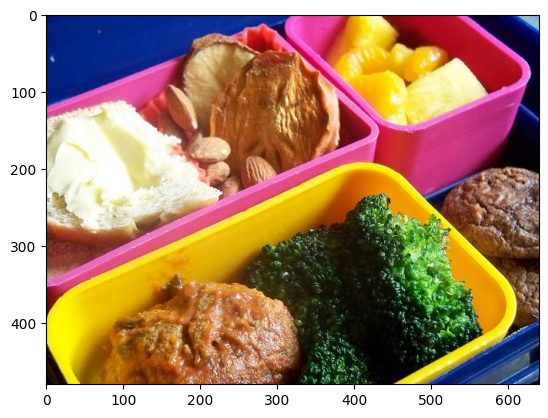

In [9]:
# THIS IS FOR TESTING
image = dataset_emb[0]["image"]

# print image
import matplotlib.pyplot as plt
plt.imshow(image)

question_embedding = get_embeddings(image)
question_embedding.shape

In [10]:
# Define emebdding retrieval functions

def get_nearest_examples(embedding, k=5):
    return dataset_emb.get_nearest_examples("embeddings", embedding.numpy(), k=k)

def plot_nearest_samples(samples):

    sample_images = samples["image"]

    fig, axs = plt.subplots(1, 5, figsize=(20, 20))
    for i, ax in enumerate(axs):
        ax.imshow(sample_images[i])
        ax.axis("off")
    plt.show()


torch.Size([768])
[ 0.59572554 25.292564   25.615015   26.06218    26.09325   ]


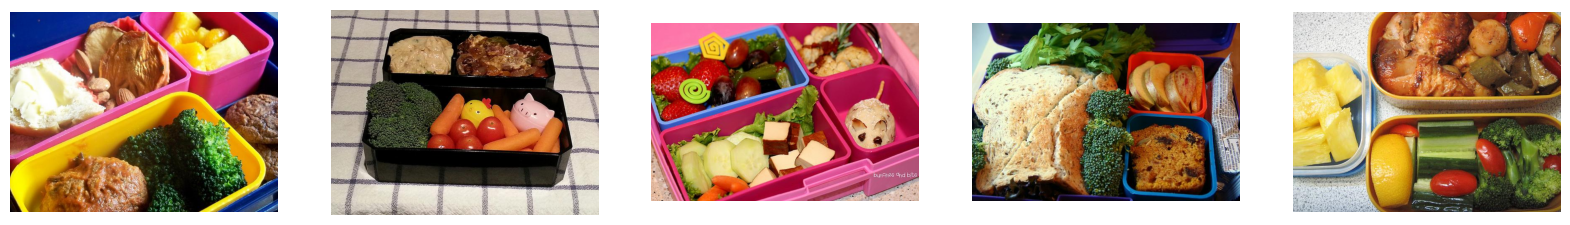

In [11]:
# THIS IS FOR TESTING
# TAKES ABOUT 20-25 SECONDS

print(torch.tensor(dataset_emb["embeddings"][32]).shape)

scores, samples = get_nearest_examples(question_embedding)
print(scores)
plot_nearest_samples(samples)

## Pix2Pix

In [12]:
# TAKES ABOUT 20-25 SECONDS

# https://huggingface.co/timbrooks/instruct-pix2pix


model_id = "timbrooks/instruct-pix2pix"
print("Loading model...")
pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(model_id, torch_dtype=torch.float16, safety_checker=None)
print("Model loaded successfully!")
pipe.to("mps")
print("Model moved to MPS successfully!")
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)
print("Scheduler loaded successfully!")





Loading model...


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Model loaded successfully!
Model moved to MPS successfully!
Scheduler loaded successfully!


In [13]:
def download_image(url):
    print("Downloading image...")
    image = PIL.Image.open(requests.get(url, stream=True).raw)
    print("Image opened successfully!")
    image = PIL.ImageOps.exif_transpose(image)
    print("transposed successfully!")
    image = image.convert("RGB")
    print(f"Image size: {image.size}")
    print("Image downloaded successfully!")
    image 
    return image

Image opened successfully!
transposed successfully!
Image size: (512, 512)
Image downloaded successfully!


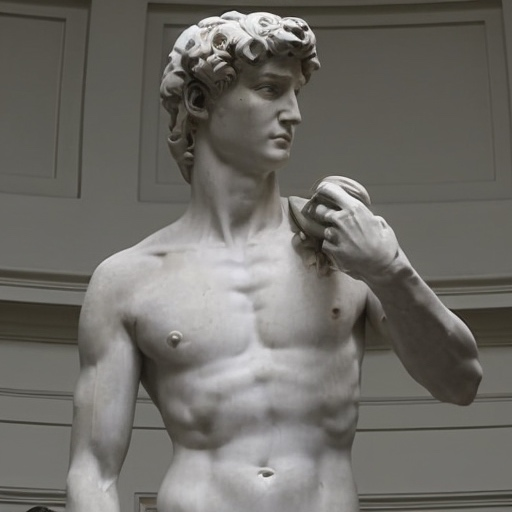

In [14]:
# THIS IS FOR TESTING
# This downloads the image - FAST
url = "https://raw.githubusercontent.com/timothybrooks/instruct-pix2pix/main/imgs/example.jpg"

image_david = download_image(url)
image_david

  0%|          | 0/10 [00:00<?, ?it/s]

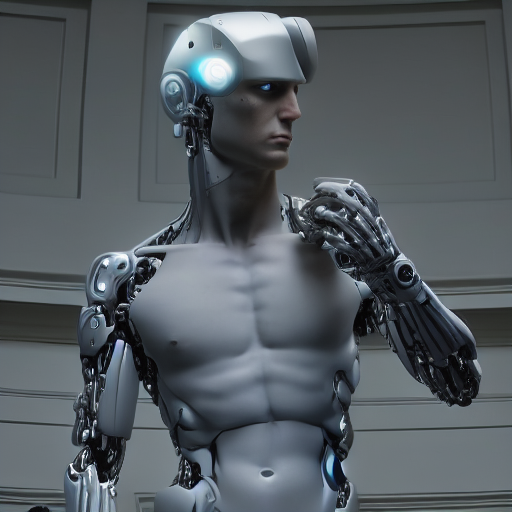

In [31]:
# THIS IS FOR TESTING
# This runs the image through the model
# TAKES ABOUT 20-25 SECONDS
# ! VERY RESOURCE INTENSIVE !
# ! NOT RECOMMENDED TO RUN ANYTHING ELSE WHILE THIS IS RUNNING !
prompt = "turn him into cyborg"
images_diffused = pipe(prompt, image=image_david, num_inference_steps=10, image_guidance_scale=1).images
images_diffused[0]

torch.Size([1, 768])


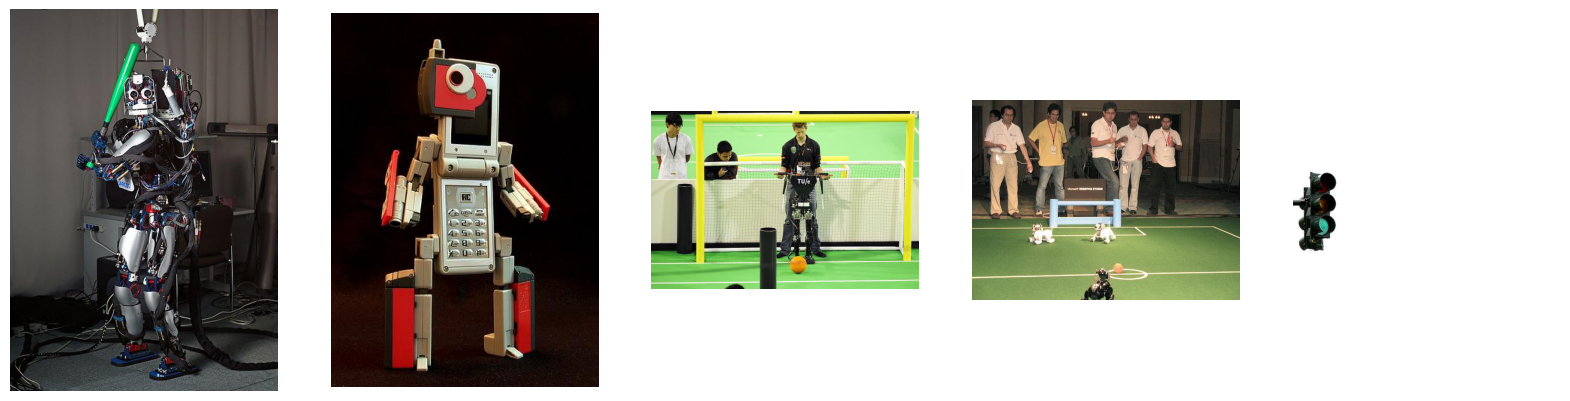

In [17]:
# THIS IS FOR TESTING
# FAST
# This gives us the closest images to the output of the model
pix2pix_embedding = get_embeddings(images[0])

pix2pix_scores, pix2pix_samples  = get_nearest_examples(pix2pix_embedding)

plot_nearest_samples(pix2pix_samples)

## UI

In [16]:
# CAPTIONING IMAGES
# We use this to try and convert the images into a textual output
# That way we can evaluate them as documents
# https://huggingface.co/nlpconnect/vit-gpt2-image-captioning
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
import torch
from PIL import Image

model_caption = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning").to("cpu")
feature_extractor_caption = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer_caption = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

# device_for_caption = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model_caption.to(device_for_caption)

In [17]:
max_length = 16
num_beams = 4
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}
def predict_caption(images):
  # mps is not supported yet
  pixel_values = feature_extractor_caption(images=images, return_tensors="pt").pixel_values.to("cpu")

  output_ids = model_caption.generate(pixel_values, **gen_kwargs)

  preds = tokenizer_caption.batch_decode(output_ids, skip_special_tokens=True)
  preds = [pred.strip() for pred in preds]
  return preds


# print(predict_caption([image_david]) )
# print(predict_caption([images_diffused[0]]))

In [18]:
# SENTENCE SIMILARITY
# This is used to compare the captions of the images -> this is our score for document similarity
# https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2
from sentence_transformers import SentenceTransformer, util
sentences = ["This is an example sentence", "example of another sentence"]

model_sentences = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings_1 = model_sentences.encode(sentences[0])
embeddings_2 = model_sentences.encode(sentences[1])
cosine_score = util.cos_sim(embeddings_1, embeddings_2)
print(str(cosine_score.item()))

tensor([[0.7423]])


In [21]:


# RELATIVELY FAST
def chameleon_search_pipeline(input_image, query_text, number_of_relevant_images):
    # ! convert the input image to a PIL image
    # an ndarray is not accepted by the model
    conformed_input_image = Image.fromarray(input_image)
    # conformed_input_image = input_image
    
    # ! Commented out for testing
    # * get the embedding of the input image
    # input_image_embedding = get_embeddings(conformed_input_image)

    # * get the closest match to the input image
    # scores, samples = get_nearest_examples(input_image_embedding, 1) # number_of_relevant_images)
    # print(scores)
    # sample_images = samples["image"]
    # closest_match_to_input_image = sample_images[0]
    # ! end of commented out for testing

    # * get the embedding of the modified image
    prompt = query_text
    image = conformed_input_image
    images = pipe(prompt, image=image, num_inference_steps=10, image_guidance_scale=1).images

    # * This is the modified image
    modified_image = images[0]   

    # * This is the caption of the modified image
    modified_image_caption = predict_caption([modified_image])[0]
    print(modified_image_caption)

    # * This is the caption of the input image
    input_image_caption = predict_caption([conformed_input_image])[0]
    print(input_image_caption)

    # * This is the cosine similarity score between the two captions
    input_image_caption_embedding = model_sentences.encode(input_image_caption)
    modified_image_caption_embedding = model_sentences.encode(modified_image_caption)
    
    # * This is supposed to be how similar the two captions are
    # However, the model for captioning (according to the title) is based on GPT2 - so captions are not the best
    cosine_score = util.cos_sim(input_image_caption_embedding, modified_image_caption_embedding)
    print("COSINE SCORE IS " + str(cosine_score.item()))

    # * WHAT WE NEED TO DO FOR THE FULL PIPELINE
    # * 1. Get the embedding of the input image
    # * 2. Get the closest match to the input image
    # * 3. Get the embedding of the modified image
    # * 4. Get the closest match to the modified image
    # * 5. Get the caption of the closest match to the input image
    # * 6. Get the caption of the closest match to the modified image
    # * 7. Get the cosine similarity score between the captions and the combination of the input image caption and the query text 
        # * 7.1. This last part is not done yet because we need to figure out how to combine the two 
        # * 7.2. We can do this by concatenating the two strings and then getting the embedding of the combined string 
        # * 7.3. Besides that most of the work is done
    # * 8. Use that for evaluation purposes

    # ! Commented out for testing
    
    # modified_image_embedding = get_embeddings(modified_image)

   

    # # get the closest match to the modified image
    # scores, samples = get_nearest_examples(modified_image_embedding, 1) # number_of_relevant_images)
    # closest_match_to_modified_image = samples["image"][0]

  
    # input_image_caption = predict_caption([conformed_input_image])[0]
    # print(input_image_caption)
    # closest_match_to_modified_image_caption = predict_caption([closest_match_to_modified_image])[0]
    # print(closest_match_to_modified_image_caption)
    # ! end of commented out for testing


    return modified_image, modified_image_caption # closest_match_to_input_image, closest_match_to_modified_image

# 3 images return the modified image, the most similiar to the input image, and the most similiar to the modified images
# todo make this return n most similiar images
demo = gr.Interface(fn=chameleon_search_pipeline, inputs=[
    # gr.Image(type="pil"),
    "image",
    "text", 
    # gr.Slider(1, 5, value=1, label="Number of similar instances", step=1, info="Number of similar instances - placeholder")
    ], 
    outputs=["image", "text"] #, "image", "text", "image", "text"]
)

print("starting demo")

demo.launch()

/Users/alves/anaconda3/envs/multimodal-search/lib/python3.9/site-packages/gradio/utils.py:951: UserWarning: Expected 3 arguments for function <function chameleon_search_pipeline at 0x455655d30>, received 2.
  warnings.warn(
/Users/alves/anaconda3/envs/multimodal-search/lib/python3.9/site-packages/gradio/utils.py:955: UserWarning: Expected at least 3 arguments for function <function chameleon_search_pipeline at 0x455655d30>, received 2.
  warnings.warn(


starting demo
Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


/Users/alves/anaconda3/envs/multimodal-search/lib/python3.9/site-packages/gradio/helpers.py:637: UserWarning: Unexpected argument. Filling with None.
  warnings.warn("Unexpected argument. Filling with None.")


  0%|          | 0/10 [00:00<?, ?it/s]

a crowd of people standing around a cow
a painting of an animal with a fire hydrant in its mouth
COSINE SCORE IS 0.2106221616268158
